<a href="https://colab.research.google.com/github/farnaz-orooji/nlp/blob/main/NER_Bidirectional_LSTM_with_ELMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter
from sklearn.metrics import classification_report

In [3]:
%%time
ds = pd.read_csv("//content/drive/MyDrive/nlp_dataset/ner_dataset.csv", encoding = 'ISO-8859-1')
ds = ds.fillna(method='ffill')

CPU times: user 661 ms, sys: 94.4 ms, total: 756 ms
Wall time: 793 ms


In [4]:
# this class is to retrieve sentenses with their POS and tags:
class SentenceGetter(object):
    
    def __init__(self, data):
        
        self.n_sent = 1
        self.data = data
        self.empttyt = False
        agg_func = lambda s : [(w,p,t) for w,p,t in 
                              zip(s["Word"].values.tolist(),
                                 s["POS"].values.tolist(),
                                 s["Tag"].values.tolist())
                              ]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        
        try:
            print("**")
            s = self.grouped['Sentenc: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s
        
        except:
            
            return None
        
getter = SentenceGetter(ds)
sentences = getter.sentences

In [5]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
#         'word[-5:]': word[-5:],
#         'word[-4:]': word[-4:],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
#         'postag[:2]': postag[:2],
#         'postag[:3]': postag[:3],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

In [6]:
def sent2features(sent):

    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):

    return [label for token, postag, label in sent]

def sent2tokens(sent):

    return [token for token, postag, label in sent]

In [7]:
X = [sent2features(s) for s in sentences]

In [8]:
y =[sent2labels(s) for s in sentences]

In [9]:
max_len = 50
X = [[w[0] for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)

In [10]:
words = set(list(ds['Word'].values))
words.add('PADword')
n_words = len(words)

tags = list(set(ds["Tag"].values))
n_tags = len(tags)
n_tags, n_words

(17, 35179)

In [11]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

2783
5


In [12]:
#from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([ 7, 15, 15, 13, 16, 16, 16, 15, 15, 15, 15, 15,  6, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
      dtype=int32)

In [13]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2021)

In [15]:
# !pip install tensorflow==1.15
# !pip install "tensorflow_hub>=0.6.0"
# !pip3 install tensorflow_text==1.15
import tensorflow as tf1
print(tf1.__version__)

1.15.0


In [14]:
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
sess = tf.Session()
K.set_session(sess)

In [16]:
batch_size = 32
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [17]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [18]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [ ]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [21]:
tag_model = Model(input_text, out)
tag_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # f1_score ro bezaram

In [22]:
tag_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (32, None, 1024)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (32, None, 1024)     6295552     lambda[0][0]                     
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (32, None, 1024)     6295552     bidirectional[0][0]              
______________________________________________________________________________________________

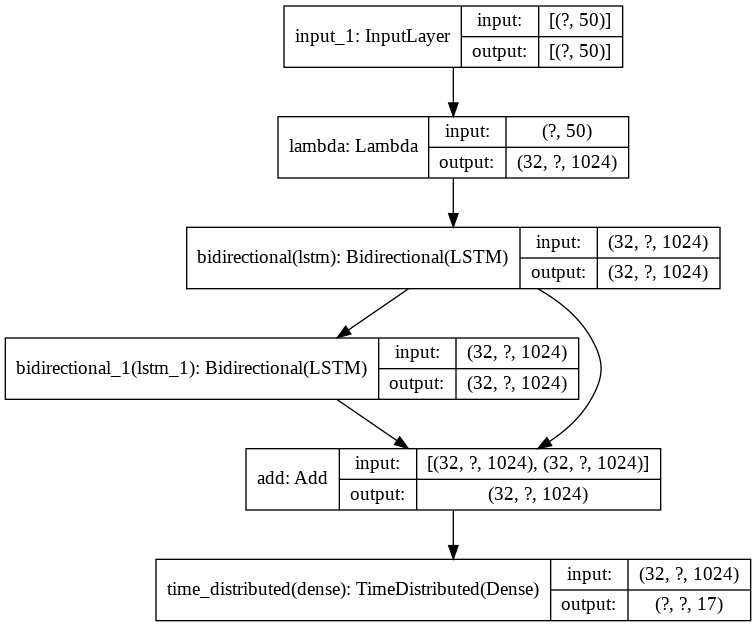

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(tag_model,'Elmo_tag.png',show_shapes= True)

In [ ]:
history = tag_model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=1, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 38816 samples, validate on 4320 samples
13024/38816 [=========>....................] - ETA: 4:16:56 - loss: 0.0870 - acc: 0.9761

In [2]:
# !pip install seqeval

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = pos_model.predict(np.array(X_te), verbose=1)

In [ ]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "."))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "."))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

In [ ]:
print(classification_report(test_labels, pred_labels))

In [ ]:
i = 395
p = pos_model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))